## Import

In [1]:
import os
import numpy as np
import fitsio

In [2]:
import fsps
import sedpy
import prospect
import time
import emcee
import h5py
import plot_utils as pread

from prospect.models import priors, sedmodel
from sedpy.observate import load_filters
from prospect import fitting
from scipy.optimize import minimize
from prospect.io import read_results, write_results
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Setup the models

In [4]:
from prospect.models import model_setup
from prospect.sources import CSPBasis, CSPSpecBasis

In [40]:
# Specify the run parameters.
run_params = {
              'param_file': '',
              'outfile': 'test',
              'verbose': True,
              'debug': False,
              'nwalkers': 50, # 128,
              'nburn': [32, 32, 64], 
              'niter': 500, # 512,
    
              'do_powell': True,
              'ftol': 0.5e-5, 'maxfev': 5000,
              #'initial_disp': 0.1,
              # Data parameters
              #'snr': 20.0, # ???
              #'add_noise': False, # ???
              # Model parameters
              #'mass': 1e10,
              #'logzsol': -0.5,
              #'tage': 12.0,
              #'tau': 3.0,
              #'dust2': 0.3,
              # Data manipulation parameters
              #'logify_spectrum': False,
              #'normalize_spectrum': False,
              #'wlo':3750., 'whi':7200.,
              # SPS parameters
              'zcontinuous': 1,
              }
print(run_params)

{'param_file': '', 'outfile': 'test', 'verbose': True, 'debug': False, 'nwalkers': 12, 'nburn': [32, 32, 64], 'niter': 50, 'do_powell': True, 'ftol': 5e-06, 'maxfev': 5000, 'zcontinuous': 1}


In [41]:
sdss = ['sdss_{}0'.format(b) for b in ['u','g','r','i','z']]
wise = ['wise_{}'.format(b) for b in ['w1','w2']]
filternames = sdss + wise
print(filternames)

['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0', 'wise_w1', 'wise_w2']


In [42]:
# load sps model (default)
#sps = model_setup.load_sps(**run_params)
sps = CSPSpecBasis(zcontinuous=1, compute_vega_mags=False)

In [43]:
print(sps.csp.libraries)

(b'pdva', b'basel')


In [44]:
filters = load_filters(filternames)
print(filters)

[<class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2)]


In [45]:
# create a function to read in the redmapper catalog and extract relavent files
def readred():
    redfile = os.path.join(os.sep, 'global', 'work', 'projects', 
                           'redmapper', 'redmapper_isedfit_v5.10_centrals.fits.gz')
    info = fitsio.FITS(redfile)
    # hack, read just one galaxy
    cat = info[1].read(rows=3)
    
    return cat

In [46]:
# Build output dictionary which contains the input photometry (our version of load_obs).
def prospcat(redcat):
    mask = (redcat['IVARMAGGIES'] > 0) * 1
    obs = {}
    obs['maggies'] = np.squeeze(redcat['MAGGIES'])
    with np.errstate(divide='ignore'):
        obs['maggies_unc'] = np.squeeze(1.0/np.sqrt(redcat['IVARMAGGIES'])) #[:3, :])
    obs['wavelength'] = None # not fitting spectra
    obs['filternames'] = filternames
    obs['filters'] = load_filters(filternames)
    obs['phot_mask'] = mask  # 1 = good, 0 = bad
    obs['isedfit_id'] = redcat['ISEDFIT_ID']
    obs['zred'] = redcat['Z']
    
    # NOT SURE IF CORRECT
    obs['unc'] = obs['maggies_unc']
    obs['spectrum'] = None
    
    return obs

In [47]:
redcat = readred()

In [48]:
obs = prospcat(redcat)
#print(obs)

In [49]:
# Load the (default?) SPS model
def load_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                   compute_vega_mags=compute_vega_mags)
    return sps

In [51]:
#sps = load_sps(**run_params)

In [52]:
# I don't think we need to load a noise model since we're only fitting photometry.(?)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

In [63]:
# Initialize the priors and then load the (default?) model.
# TBD: Do we need to define priors on dust, fburst, etc., etc.???
def load_model(zred, **extras):
    model_params = []
    
    # Prior on distance / redshift.
    model_params.append({'name': 'zred', 'N': 1,
                         'isfree': False,
                         'init': zred,
                         'units': '',
                         'prior_function': priors.tophat,
                         'prior_args': {'mini': 0.0, 'maxi': 4.0}})
    
    # Prior on SFH.
    model_params.append({'name': 'sfh', 'N': 1,
                         'isfree': False,
                         'init': 4,
                         'units': 'type'})

    model_params.append({'name': 'mass', 'N': 1,
                         'isfree': True,
                         'init': 1e11,
                         'init_disp': 1e10,
                         'units': r'M_\odot',
                         'prior_function': priors.tophat,
                         'prior_args': {'mini': 1e10, 'maxi': 5e12}})

    model_params.append({'name': 'logzsol', 'N': 1,
                         'isfree': False,
                         'init': -0.3,
                         'init_disp': 0.3,
                         'units': r'$\log (Z/Z_\odot)$',
                         'prior_function': priors.tophat,
                         'prior_args': {'mini':-1, 'maxi':0.19}})
    
    # Metallicity, tau, and age priors
    # If zcontinuous > 1, use 3-pt smoothing
    model_params.append({'name': 'pmetals', 'N': 1,
                         'isfree': False,
                         'init': 0.02,})
                        
    model_params.append({'name': 'tau', 'N': 1,
                         'isfree': False,
                         'init': 1.0,
                         'init_disp': 0.5,
                         'units': 'Gyr',
                         'prior_function': priors.logarithmic,
                         'prior_args': {'mini': 0.1, 'maxi': 100}})

    model_params.append({'name': 'tage', 'N': 1,
                        'isfree': True,
                        'init': 10.0,
                        'init_disp': 3.0,
                        'units': 'Gyr',
                        'prior_function': priors.tophat,
                        'prior_args': {'mini': 0.101, 'maxi': 14.0}})
    
# Ben's speed solution:
    model_params.append({'name': 'mass_units', 'N': 1,
                        'isfree': False,
                        'init': 'mformed'})
    
    return sedmodel.SedModel(model_params)

In [64]:
model = load_model(obs['zred'], **run_params)

In [55]:
# Ben's speed solution:
if False:
    sps = CSPSpecBasis(**run_params)
    sps2 = CSPBasis(**run_params)
    s, p, x = model.mean_model(model.initial_theta, obs=obs, sps=sps)
    sps2.csp.params.dirtiness = 1  # just to make sure the model is fully recalculated
    s2, p2, x2 = model.mean_model(model.initial_theta, obs=obs, sps=sps2)
    assert np.allclose(p2, p)
    print(p2 - p)

In [65]:
# Define our likelihood function
def lnprobfn(theta, verbose=True):
    """Given a parameter vector and a dictionary of observational data and a model object, 
    return the ln of the posterior. This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    lnp_prior = model.prior_product(theta)
    if isfinite(lnp_prior):
        
        # Generate mean model
        t1 = time.time()
        try:
            mu, phot, x = model.mean_model(theta, obs, sps=sps)
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling
        if spec_noise is not None:
            spec_noise.update(**model.params)
        if phot_noise is not None:
            phot_noise.update(**model.params)
        vectors = {'spec': mu, 'unc': obs['unc'],
                   'sed': model._spec, 'cal': model._speccal,
                   'phot': phot, 'maggies_unc': obs['maggies_unc']}

        # Calculate log-likelihoods
        t2 = time.time()
        lnp_spec = lnlike_spec(mu, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec

    else:
        return -np.infty

# Running Prospector

### Outputs

In [66]:
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = '{}_mcmc.h5'.format(outroot)
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file test_1496430515_mcmc.h5
Could not JSON serialize model_params, pickled instead


### Model Preview

In [67]:
print('Free parameters: ', model.free_params)
print('Fixed parameters: ', model.fixed_params)

Free parameters:  ['mass', 'tage']
Fixed parameters:  ['zred', 'sfh', 'logzsol', 'pmetals', 'tau', 'mass_units']


### SED Preview

In [68]:
model.initial_theta

array([  1.00000000e+11,   1.00000000e+01])

In [69]:
sps.csp.wavelengths

array([  9.10000000e+01,   9.40000000e+01,   9.60000000e+01, ...,
         9.81700000e+07,   9.90800000e+07,   1.00000000e+08])

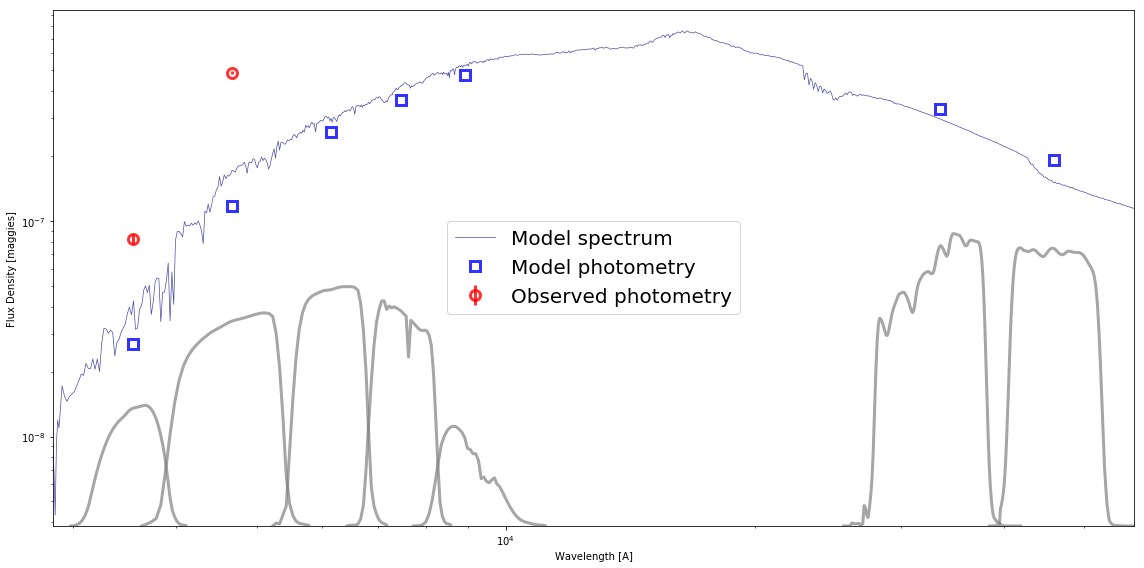

In [70]:
wspec = sps.csp.wavelengths # spectral wavelengths
wphot = array([f.wave_effective for f in obs['filters']]) # photometric effective wavelengths
wphot_width = array([f.effective_width for f in obs['filters']]) # photometric effective widths

initial_theta = model.rectify_theta(model.initial_theta) # initial parameters
mspec_init, mphot_init, mextra_init = model.mean_model(initial_theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in range(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()



### Minimization Step

In [71]:
# Do we actually need this?
try:
    from emcee.utils import MPIPool
    pool = MPIPool(debug=False, loadbalance=True)
    if not pool.is_master():
        # Wait for instructions from the master process.
        pool.wait()
        sys.exit(0)
except(ImportError, ValueError):
    pool = None
    print('Not using MPI')

Not using MPI


In [72]:
def halt(message):
    """Exit, closing pool safely.
    """
    print(message)
    try:
        pool.close()
    except:
        pass

In [73]:
def chisqfn(theta):
    """Negative of lnprobfn for minimization, and also handles passing in
    keyword arguments which can only be postional arguments when using scipy
    minimize.
    """
    return -lnprobfn(theta)

verbose=False # don't output function calls

# start minimization
min_method = 'Nelder-Mead'
ts = time.time()
min_results = minimize(chisqfn, initial_theta, method=min_method)
pdur = time.time() - ts

# reinitialize fit
initial_center = fitting.reinitialize(min_results.x, model, edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = -1 * min_results['fun']

# output results
print('done {0} in {1}s'.format(min_method,pdur))
print('best {0} guess: {1}'.format(min_method,initial_center))
print('best {0} lnp: {1}'.format(min_method,initial_prob))

[  1.00000000e+11   1.00000000e+01]
model calc = 0.003836393356323242s, lnlike calc = 0.00010657310485839844
lnp = -5666.130862493828, lnp_spec = 0.0, lnp_phot = -5666.130862493828
[  1.05000000e+11   1.00000000e+01]
model calc = 0.0027997493743896484s, lnlike calc = 8.726119995117188e-05
lnp = -5483.551084582022, lnp_spec = 0.0, lnp_phot = -5483.551084582022
[  1.00000000e+11   1.05000000e+01]
model calc = 0.009768009185791016s, lnlike calc = 6.794929504394531e-05
lnp = -5889.749452504872, lnp_spec = 0.0, lnp_phot = -5889.749452504872
[  1.05000000e+11   9.50000000e+00]
model calc = 0.007464885711669922s, lnlike calc = 6.4849853515625e-05
lnp = -5211.880117059647, lnp_spec = 0.0, lnp_phot = -5211.880117059647
[  1.07500000e+11   9.00000000e+00]
model calc = 0.007374286651611328s, lnlike calc = 6.198883056640625e-05
lnp = -4790.756272846931, lnp_spec = 0.0, lnp_phot = -4790.756272846931
[  1.12500000e+11   9.00000000e+00]
model calc = 0.00222015380859375s, lnlike calc = 6.1988830566406

[  1.40710872e+11   5.52167096e+00]
model calc = 0.007677555084228516s, lnlike calc = 6.222724914550781e-05
lnp = 123.15818495099165, lnp_spec = 0.0, lnp_phot = 123.15818495099165
[  1.40359965e+11   5.51529878e+00]
model calc = 0.0066699981689453125s, lnlike calc = 6.151199340820312e-05
lnp = 123.15818306144345, lnp_spec = 0.0, lnp_phot = 123.15818306144345
[  1.40427598e+11   5.51641824e+00]
model calc = 0.0067331790924072266s, lnlike calc = 6.127357482910156e-05
lnp = 123.15814685954898, lnp_spec = 0.0, lnp_phot = 123.15814685954898
[  1.40589329e+11   5.51951819e+00]
model calc = 0.006719350814819336s, lnlike calc = 6.222724914550781e-05
lnp = 123.15818781316757, lnp_spec = 0.0, lnp_phot = 123.15818781316757
[  1.40940236e+11   5.52589037e+00]
model calc = 0.0067369937896728516s, lnlike calc = 6.651878356933594e-05
lnp = 123.15818704283608, lnp_spec = 0.0, lnp_phot = 123.15818704283608
[  1.40818693e+11   5.52373760e+00]
model calc = 0.00658726692199707s, lnlike calc = 6.1750411987

lnp = 123.15818786621087, lnp_spec = 0.0, lnp_phot = 123.15818786621087
[  1.40687002e+11   5.52128197e+00]
model calc = 0.007321596145629883s, lnlike calc = 6.198883056640625e-05
lnp = 123.15818786621092, lnp_spec = 0.0, lnp_phot = 123.15818786621092
[  1.40681552e+11   5.52118325e+00]
model calc = 0.006677389144897461s, lnlike calc = 6.151199340820312e-05
lnp = 123.15818786621092, lnp_spec = 0.0, lnp_phot = 123.15818786621092
[  1.40685640e+11   5.52125729e+00]
model calc = 0.006697893142700195s, lnlike calc = 6.222724914550781e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40682915e+11   5.52120793e+00]
model calc = 0.0066754817962646484s, lnlike calc = 6.222724914550781e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684959e+11   5.52124495e+00]
model calc = 0.006525516510009766s, lnlike calc = 6.151199340820312e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684277e+11   5.52123

[  1.40684650e+11   5.52123936e+00]
model calc = 0.0070688724517822266s, lnlike calc = 6.818771362304688e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.0069026947021484375s, lnlike calc = 5.984306335449219e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.00667572021484375s, lnlike calc = 6.580352783203125e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123935e+00]
model calc = 0.006677865982055664s, lnlike calc = 5.888938903808594e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.006424903869628906s, lnlike calc = 5.91278076171875e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.00639033317565918s, lnlike calc = 6.6280364990234

[  1.40684650e+11   5.52123936e+00]
model calc = 0.0070934295654296875s, lnlike calc = 6.175041198730469e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.006494045257568359s, lnlike calc = 5.888938903808594e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.006598949432373047s, lnlike calc = 5.888938903808594e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.0066950321197509766s, lnlike calc = 5.841255187988281e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.006481647491455078s, lnlike calc = 5.745887756347656e-05
lnp = 123.15818786621094, lnp_spec = 0.0, lnp_phot = 123.15818786621094
[  1.40684650e+11   5.52123936e+00]
model calc = 0.0064966678619384766s, lnlike calc = 5.698204040

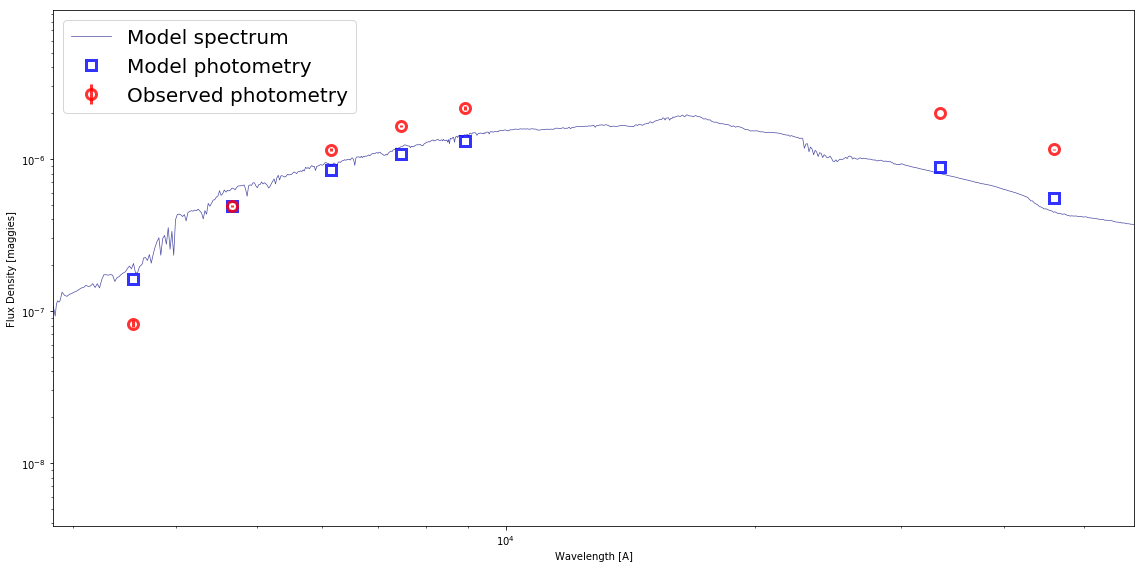

In [75]:
# Check that we got closer!
mspec_init, mphot_init, mextra_init = model.mean_model(min_results.x, obs, sps=sps) # generate model

# plotting 
figure(figsize=(16,8))
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax*10])
legend(loc='best', fontsize=20)
tight_layout()

### Sampling the Posterior

In [76]:
postkwargs = {}

fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

tstart = time.time()
#out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
#                                postkwargs=postkwargs, initial_prob=initial_prob,
#                                pool=pool, hdf5=hfile, **run_params)
#esampler, burn_p0, burn_prob0 = out

esampler, burn_p0, burn_prob0 = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                postkwargs=postkwargs, initial_prob=initial_prob,
                                pool=pool, hdf5=hfile, **run_params)
#esampler, burn_p0, burn_prob0 = out

edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

done emcee in 14.550545930862427s


In [77]:
print(initial_center)
print(initial_prob)

[  1.40684650e+11   5.52123936e+00]
123.158187866


In [78]:
# Pick a random walker at the end!
theta = esampler.chain[5, run_params['niter']-1, :]
#theta = esampler.chain[5, 100, :]
print(theta)

mspec_init, mphot_init, mextra_init = model.mean_model(theta, obs, sps=sps) # generate model

IndexError: index 49 is out of bounds for axis 1 with size 0

In [35]:
esampler.chain.shape

(10, 0, 2)

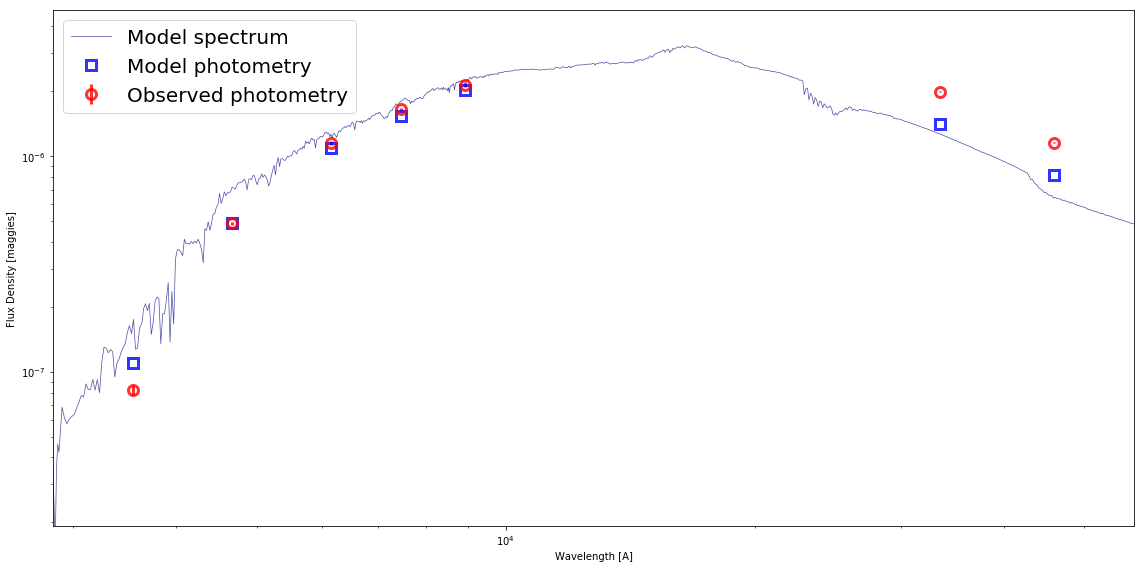

In [36]:
# plotting 
figure(figsize=(16,8))
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


In [34]:
# Saves results to a disk - Error 
write_results.write_pickles(run_params, model, obs, esampler, min_results,
                            outroot=outroot, toptimize=pdur, tsample=edur,
                            sampling_initial_center=initial_center,
                            post_burnin_center=burn_p0,
                            post_burnin_prob=burn_prob0)

if hfile is None:
    hfile = hfilename
write_results.write_hdf5(hfile, run_params, model, obs, esampler, min_results,
                         toptimize=pdur, tsample=edur,                         
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_p0,
                         post_burnin_prob=burn_prob0)

halt('Finished')

TypeError: expected str, bytes or os.PathLike object, not File

# Visualizing the Results

In [ ]:
# grab results, powell results, and our corresponding models -Error
res, pr, mod = read_results.results_from("{}_1496243536_mcmc.h5".format(run_params['outfile']))